# Import

In [1]:
# Install geneal without pulling in incompatible pinned dependencies
!pip install geneal --no-deps

# Then install compatible versions manually
!pip install numba matplotlib networkx pandas scikit-learn

In [2]:
# Clone the first repo
!git clone https://github.com/lan-j/unfair_dataset_generation.git
%cd unfair_dataset_generation
'''
# Change the current directory to the first repo
import os
os.chdir('unfair_dataset_generation')

# Clone the second repo
os.chdir('/content') # Move back to the /content directory
!git clone https://github.com/diogomatoschaves/geneal

# Change the current directory to the second repo
#os.chdir('geneal')
'''

Cloning into 'unfair_dataset_generation'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 88 (delta 41), reused 20 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (88/88), 222.30 KiB | 20.21 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/unfair_dataset_generation


"\n# Change the current directory to the first repo\nimport os\nos.chdir('unfair_dataset_generation')\n\n# Clone the second repo\nos.chdir('/content') # Move back to the /content directory\n!git clone https://github.com/diogomatoschaves/geneal\n\n# Change the current directory to the second repo\n#os.chdir('geneal')\n"

In [ ]:
!python main.py --help

usage: main.py [-h] [--generate_reference] [--dataset DATASET]
               [--unfair_metric UNFAIR_METRIC] [--label_name LABEL_NAME]
               [--sensitive_name SENSITIVE_NAME] [--save_unfair_dataset]

simulated dataset

options:
  -h, --help            show this help message and exit
  --generate_reference
  --dataset DATASET
  --unfair_metric UNFAIR_METRIC
                        overall_accuracy_equality, statistical_parity,
                        conditional_procedure,
                        conditional_use_accuracy_equality, treatment_equality,
                        all_equality, calibration
  --label_name LABEL_NAME
                        name of prediction
  --sensitive_name SENSITIVE_NAME
                        name of sensitive feature
  --save_unfair_dataset
                        add argument to save simulated unfair dataset


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import re

# Adult Census Modifications

In [4]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
                'marital-status', 'occupation', 'relationship', 'race', 'sex',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

train_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

train = pd.read_csv(train_url, header=None, names=cols, na_values=' ?')
test = pd.read_csv(test_url, header=0, names=cols, na_values=' ?')

data = pd.concat([train, test], axis=0).dropna()

for col_name in data.columns:
    if data[col_name].dtype == object:  # Check if column is of type string (object)
        data[col_name] = data[col_name].apply(
            lambda x: re.sub(r'[.,]', '', x.strip()) if isinstance(x, str) else x
        )

data['income'] = data['income'].apply(lambda x: 1 if '>50K' in x else 0)
data['sex'] = data['sex'].apply(lambda x: 1 if x == 'Male' else 0)
data['race'] = data['race'].apply(lambda x: 1 if x == 'White' else 0)

#cat_features = data.select_dtypes(include='object').columns.tolist()

#data_OHE = pd.get_dummies(data, columns=cat_features, drop_first=True)

print(data.isnull().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [ ]:
data['income'].value_counts()

,count
income,
0,34014
1,11208


In [5]:
data = data.drop(['fnlwgt', 'education'], axis=1)
data['marital-status'] = [1 if x=='Married-civ-spouse' else 0 for x in data['marital-status']]
data['native-country'] = [1 if x=='United-States' else 0 for x in data['native-country']]

occ_groups = {
    'Priv-house-serv':0,'Other-service':0,'Handlers-cleaners':0,
    'Farming-fishing':1,'Machine-op-inspct':1,'Adm-clerical':1,
    'Transport-moving':2,'Craft-repair':2,'Sales':2, '?': -1,
    'Armed-Forces':3,'Tech-support':3,'Protective-serv':3,
    'Prof-specialty':4,'Exec-managerial':4}

data['occupation'] = [occ_groups[x] for x in data['occupation']]
data['workclass'] = [1 if x=='Private' else 0 for x in data['workclass']]
data['relationship'] = [1 if x=='Husband' else 0 for x in data['relationship']]

In [6]:
# Adult
output_csv_name = "adult_processed.csv"
output_path = os.path.join("/content/unfair_dataset_generation/datasets", output_csv_name)
data.to_csv(output_path, index=False)
print(f"\nProcessed dataset saved as {output_csv_name}")
print("First 5 rows of the processed dataset:")
print(data.head())


Processed dataset saved as adult_processed.csv
First 5 rows of the processed dataset:
   age  workclass  education-num  marital-status  occupation  relationship  \
0   39          0             13               0           1             0   
1   50          0             13               1           4             1   
2   38          1              9               0           0             0   
3   53          1              7               1           0             1   
4   28          1             13               1           4             0   

   race  sex  capital-gain  capital-loss  hours-per-week  native-country  \
0     1    1          2174             0              40               1   
1     1    1             0             0              13               1   
2     1    1             0             0              40               1   
3     0    1             0             0              40               1   
4     0    0             0             0              40        

In [7]:
# Execute Adult
!python main.py --unfair_metric 2 --dataset "adult_processed.csv" --label_name "income" --sensitive_name "race" --save_unfair_dataset

Streaming output truncated to the last 5000 lines.
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: UnfairnessMetric.__call__() got an unexpected keyword argument 'needs_proba'

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: UnfairnessMetric.__call__() got an unexpected keyword argument 'needs_proba'

  warnings.warn(
/usr/local/lib/python3.1

In [ ]:
# Execute Adult
!python main.py --unfair_metric 2 --dataset "adult_processed.csv" --label_name "income" --sensitive_name "sex" --save_unfair_dataset

Streaming output truncated to the last 5000 lines.
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: UnfairnessMetric.__call__() got an unexpected keyword argument 'needs_proba'

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: UnfairnessMetric.__call__() got an unexpected keyword argument 'needs_proba'

  warnings.warn(
/usr/local/lib/python3.1

In [8]:
# Load the dataset
df_1 = pd.read_csv('/content/unfair_dataset_generation/datasets/adult_processed_unfair_lr_1.csv')

In [ ]:
df_1

,age,workclass,education-num,marital-status,occupation,relationship,race,capital-gain,capital-loss,hours-per-week,native-country,sex,income
0,39,0,13,0,1,0,0,2174,0,40,1,0,0
1,50,0,13,1,4,1,0,0,0,13,1,0,0
2,38,1,9,0,0,0,0,0,0,40,1,0,0
3,53,1,7,1,0,1,0,0,0,40,1,0,0
4,28,1,13,1,4,0,0,0,0,40,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33,1,13,0,4,0,0,0,0,40,1,0,0
45218,39,1,13,0,4,0,0,0,0,36,1,0,0
45219,38,1,13,1,4,1,0,0,0,50,1,0,0
45220,44,1,13,0,1,0,0,5455,0,40,1,0,0


ValueError: num must be an integer with 1 <= num <= 6, not 7

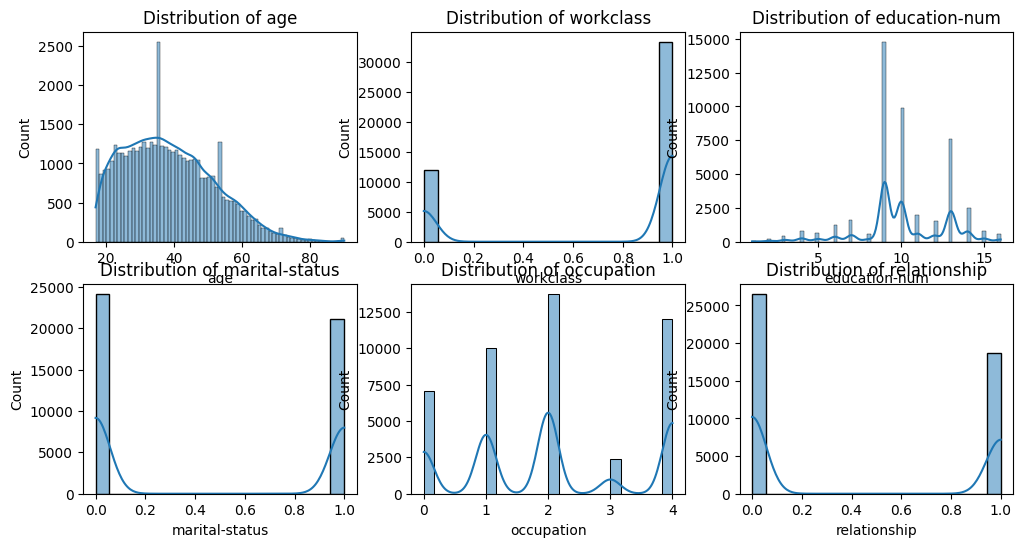

In [ ]:
# Create feature distribution plots for df_1
plt.figure(figsize=(12, 6))
for i, col in enumerate(df_1.columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df_1, x=col, kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [9]:
df_original = pd.read_csv('/content/unfair_dataset_generation/datasets/adult_processed.csv')
#df_unfair = pd.read_csv('/content/unfair_dataset_generation/datasets/adult_processed_unfair_lr_1_new.csv')
#df_unfair2 = pd.read_csv('/content/unfair_dataset_generation/datasets/adult_processed_unfair_lr_2.csv')
df_unfair = pd.read_csv('/content/unfair_dataset_generation/datasets/adult_processed_unfair_lr_1.csv')

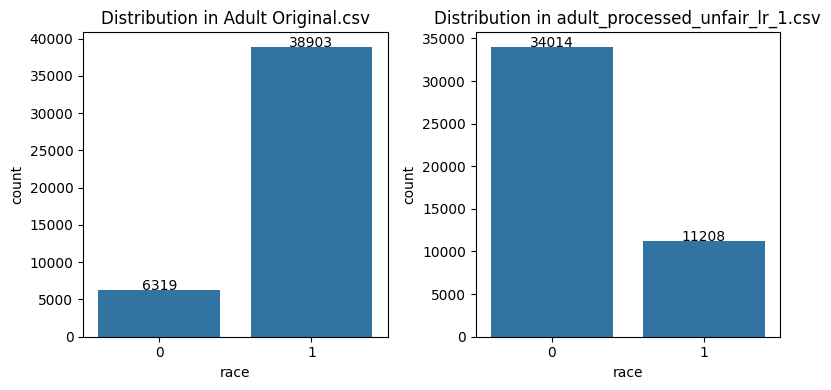

In [12]:
# Create plots to compare the distribution of 'Gender' in StudentPerformance
plt.figure(figsize=(8, 4))

# First subplot: original dataset
plt.subplot(1, 2, 1)
ax1 = sns.countplot(data=df_original, x='race')
plt.title('Distribution in Adult Original.csv')

# Add counts on top of bars
for p in ax1.patches:
    count = int(p.get_height())
    ax1.text(p.get_x() + p.get_width() / 2., p.get_height() + 1,
             str(count), ha="center")

# Second subplot: unfair dataset
plt.subplot(1, 2, 2)
ax2 = sns.countplot(data=df_unfair, x='race')
plt.title('Distribution in adult_processed_unfair_lr_1.csv')

# Add counts on top of bars
for p in ax2.patches:
    count = int(p.get_height())
    ax2.text(p.get_x() + p.get_width() / 2., p.get_height() + 1,
             str(count), ha="center")

plt.tight_layout()
plt.show()

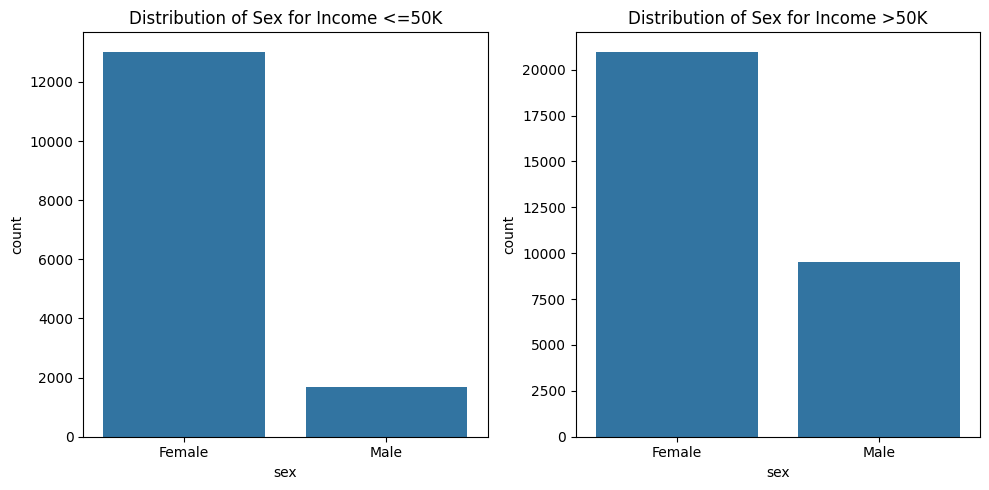

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=df_unfair2[df_unfair2['income'] == 0], x='sex')
plt.title('Distribution of Sex for Income <=50K')
plt.xticks([0, 1], ['Female', 'Male'])

plt.subplot(1, 2, 2)
sns.countplot(data=df_unfair2[df_unfair2['income'] == 1], x='sex')
plt.title('Distribution of Sex for Income >50K')
plt.xticks([0, 1], ['Female', 'Male'])

plt.tight_layout()
plt.show()

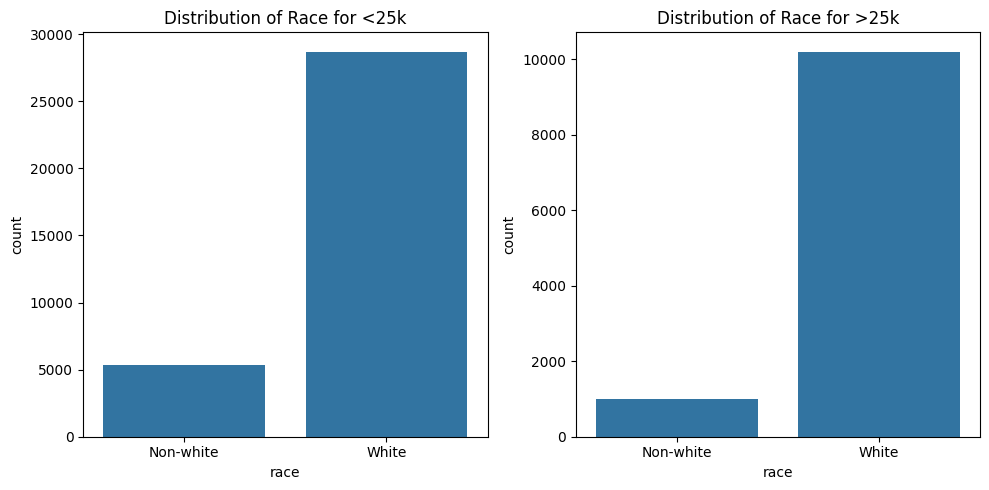

In [13]:
# Show distribution of Race by outcome for original datset

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=df_original[df_original['income'] == 0], x='race')
plt.title('Distribution of Race for <50k')
plt.xticks([0, 1], ['Non-white', 'White'])

plt.subplot(1, 2, 2)
sns.countplot(data=df_original[df_original['income'] == 1], x='race')
plt.title('Distribution of Race for >50k')
plt.xticks([0, 1], ['Non-white', 'White'])


plt.tight_layout()
plt.show()

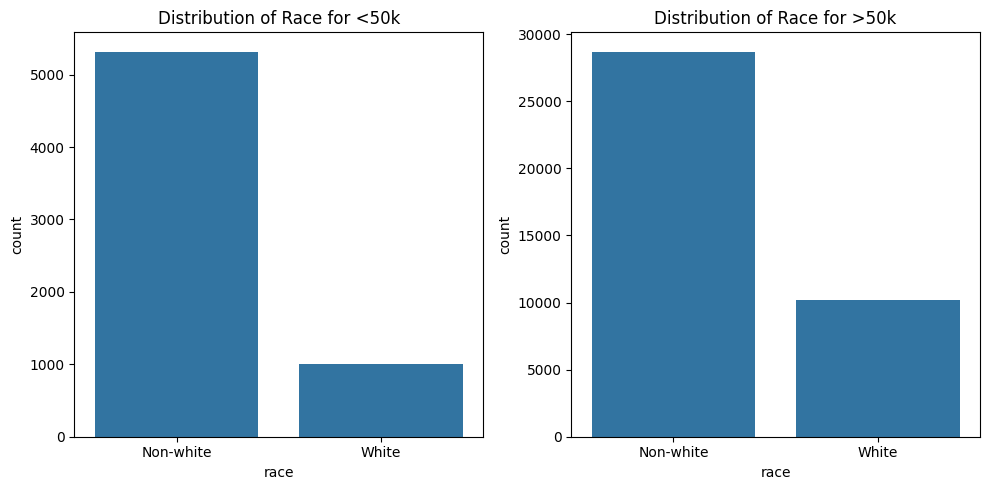

In [14]:
# Show distribution of Race by outcome for unfair datset

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=df_unfair[df_unfair['income'] == 0], x='race')
plt.title('Distribution of Race for <50k')
plt.xticks([0, 1], ['Non-white', 'White'])

plt.subplot(1, 2, 2)
sns.countplot(data=df_unfair[df_unfair['income'] == 1], x='race')
plt.title('Distribution of Race for >50k')
plt.xticks([0, 1], ['Non-white', 'White'])


plt.tight_layout()
plt.show()

# German Credit Modifications

In [ ]:
# German Credit
# Load German dataset (assumes it's already downloaded or available as CSV)

cols = [
    'checking_status', 'duration', 'credit_history', 'purpose', 'amount',
    'savings', 'employment', 'installment_rate', 'personal_status_sex',
    'other_debtors', 'residence_since', 'property', 'age',
    'other_installment_plans', 'housing', 'existing_credits',
    'job', 'people_liable', 'telephone', 'foreign_worker', 'credit_risk'
]

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

data = pd.read_csv(url, header=None, delim_whitespace=True, names=cols)


# Convert target: 1 = good, 2 = bad (change to 0)
data['credit_risk'] = data['credit_risk'].map({1: 1, 2: 0})

# Map binary features
data['foreign_worker'] = data['foreign_worker'].map({'A201': 1, 'A202': 0})
data['telephone'] = data['telephone'].map({'A192': 1, 'A191': 0})

# Group personal_status into gender (Male = 1, Female = 0) and marital status (Single = 0, Married/Divorced/Separated = 1)
data['sex'] = data['personal_status_sex'].apply(lambda x: 1 if x in ['A91', 'A93', 'A94'] else 0)
data['marital_status'] = data['personal_status_sex'].apply(lambda x: 1 if x in ['A92', 'A94', 'A91'] else 0)

# Convert Age to Binary groups
data['age'] = data['age'].apply(lambda x: 1 if x > 25 else 0)

# Collapse housing into binary: own = 1, else 0
data['housing'] = data['housing'].map({'A152': 1, 'A153': 0, 'A151': 0})

# Collapse status of checking account into binary: with money = 1, little money / no account = 0
data['checking_status'] = data['checking_status'].map({'A12': 1, 'A13': 1, 'A11': 0, 'A14': 0})

# Collapse status of credit history into binary: with unpaid credit = 0 else 1
data['credit_history'] = data['credit_history'].map({'A30': 1, 'A31': 1, 'A32': 1,'A33': 0, 'A34': 0})

# Collapse employment status:
data['employment'] = data['employment'].map({'A75': 4, 'A74': 3, 'A73': 2,'A72': 1, 'A71': 0})

# Collapse job: skilled/unskilled
job_map = {'A171': 0, 'A172': 0, 'A173': 1, 'A174': 2}
data['job'] = data['job'].map(job_map)

# Drop redundant or non-numeric columns
drop_cols = ['checking_status', 'duration', 'purpose', 'savings', 'installment_rate', 'personal_status_sex',
             'other_debtors', 'property', 'other_installment_plans', 'existing_credits', 'people_liable']
data = data.drop(columns=drop_cols)

# Optional: Reset index
data.reset_index(drop=True, inplace=True)

print(data.head())

/tmp/ipython-input-4279537377.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(url, header=None, delim_whitespace=True, names=cols)


   credit_history  amount  employment  residence_since  age  housing  job  \
0               0    1169           4                4    1        1    1   
1               1    5951           2                2    0        1    1   
2               0    2096           3                3    1        1    0   
3               1    7882           3                4    1        0    1   
4               0    4870           2                4    1        0    1   

   telephone  foreign_worker  credit_risk  sex  marital_status  
0          1               1            1    1               0  
1          0               1            0    0               1  
2          0               1            1    1               0  
3          0               1            1    1               0  
4          0               1            0    1               0  


In [ ]:
data

,credit_history,amount,employment,residence_since,age,housing,job,telephone,foreign_worker,credit_risk,sex,marital_status
0,0,1169,4,4,67,1,1,1,1,1,1,0
1,1,5951,2,2,22,1,1,0,1,0,0,1
2,0,2096,3,3,49,1,0,0,1,1,1,0
3,1,7882,3,4,45,0,1,0,1,1,1,0
4,0,4870,2,4,53,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,1736,3,4,31,1,0,0,1,1,0,1
996,1,3857,2,4,40,1,2,1,1,1,1,1
997,1,804,4,4,38,1,1,0,1,1,1,0
998,1,1845,2,4,23,0,1,1,1,0,1,0


In [ ]:
# German
output_csv_name = "german_processed.csv"
output_path = os.path.join("/content/unfair_dataset_generation/datasets", output_csv_name)
data.to_csv(output_path, index=False)
print(f"\nProcessed dataset saved as {output_csv_name}")
print("First 5 rows of the processed dataset:")
print(data.head())


Processed dataset saved as german_processed.csv
First 5 rows of the processed dataset:
   credit_history  amount  employment  residence_since  age  housing  job  \
0               0    1169           4                4    1        1    1   
1               1    5951           2                2    0        1    1   
2               0    2096           3                3    1        1    0   
3               1    7882           3                4    1        0    1   
4               0    4870           2                4    1        0    1   

   telephone  foreign_worker  credit_risk  sex  marital_status  
0          1               1            1    1               0  
1          0               1            0    0               1  
2          0               1            1    1               0  
3          0               1            1    1               0  
4          0               1            0    1               0  


In [ ]:
# Execute German
!python main.py --unfair_metric 2 --dataset "german_processed.csv" --label_name "credit_risk" --sensitive_name "age" --save_unfair_dataset

Streaming output truncated to the last 5000 lines.
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: UnfairnessMetric.__call__() got an unexpected keyword argument 'needs_proba'

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: UnfairnessMetric.__call__() got an unexpected keyword argument 'needs_proba'

  warnings.warn(
/usr/local/lib/python3.1

In [ ]:
df_original = pd.read_csv('/content/unfair_dataset_generation/datasets/german_processed.csv')
df_unfair = pd.read_csv('/content/unfair_dataset_generation/datasets/german_processed_unfair_lr_1.csv')

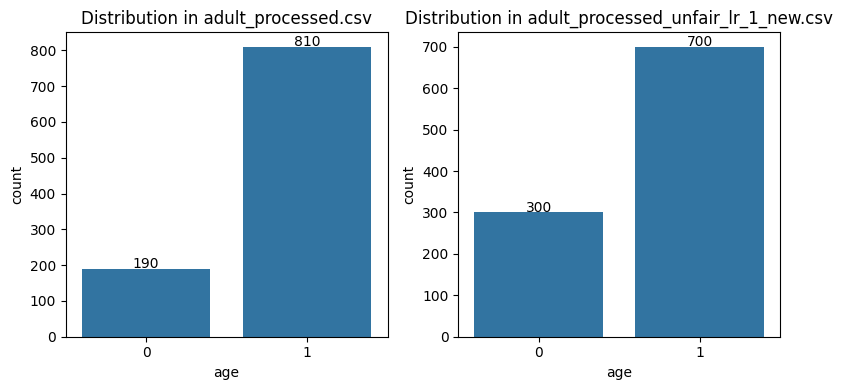

In [ ]:
# Create plots to compare the distribution of 'age' in GermanCredit
plt.figure(figsize=(8, 4))

# First subplot: original dataset
plt.subplot(1, 2, 1)
ax1 = sns.countplot(data=df_original, x='age')
plt.title('Distribution in adult_processed.csv')

# Add counts on top of bars
for p in ax1.patches:
    count = int(p.get_height())
    ax1.text(p.get_x() + p.get_width() / 2., p.get_height() + 1,
             str(count), ha="center")

# Second subplot: unfair dataset
plt.subplot(1, 2, 2)
ax2 = sns.countplot(data=df_unfair, x='age')
plt.title('Distribution in adult_processed_unfair_lr_1_new.csv')

# Add counts on top of bars
for p in ax2.patches:
    count = int(p.get_height())
    ax2.text(p.get_x() + p.get_width() / 2., p.get_height() + 1,
             str(count), ha="center")

plt.tight_layout()
plt.show()

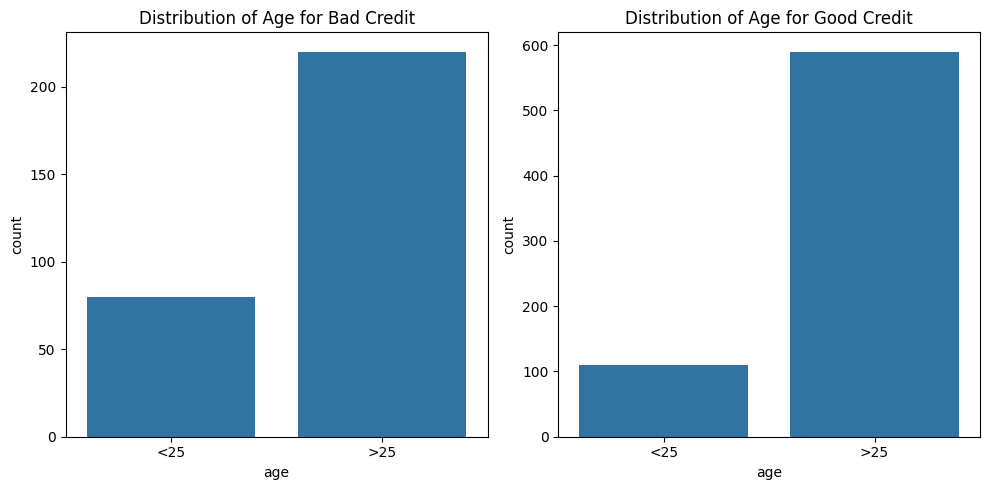

In [ ]:
# Show distribution of marital_status by income

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=df_original[df_original['credit_risk'] == 0], x='age')
plt.title('Distribution of Age for Bad Credit')
plt.xticks([0, 1], ['<25', '>25'])

plt.subplot(1, 2, 2)
sns.countplot(data=df_original[df_original['credit_risk'] == 1], x='age')
plt.title('Distribution of Age for Good Credit')
plt.xticks([0, 1], ['<25', '>25'])

plt.tight_layout()
plt.show()

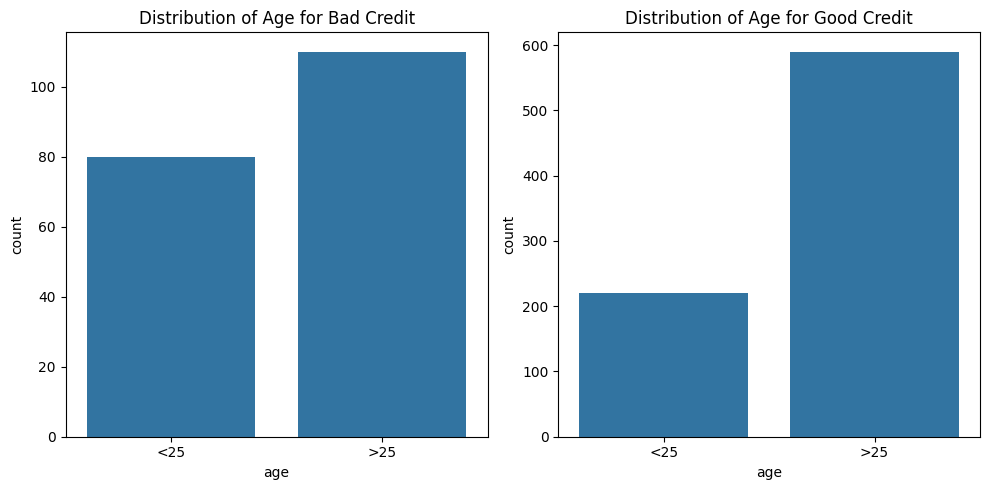

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=df_unfair[df_unfair['credit_risk'] == 0], x='age')
plt.title('Distribution of Age for Bad Credit')
plt.xticks([0, 1], ['<25', '>25'])

plt.subplot(1, 2, 2)
sns.countplot(data=df_unfair[df_unfair['credit_risk'] == 1], x='age')
plt.title('Distribution of Age for Good Credit')
plt.xticks([0, 1], ['<25', '>25'])

plt.tight_layout()
plt.show()

# Student Prediction Modification

In [ ]:
pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

In [ ]:
# Fetch dataset
dataset = fetch_ucirepo(id=697)

# Import data
X = dataset.data.features
y = dataset.data.targets

y['dropout'] = y['Target'].apply(lambda x: 0 if x == 'Dropout' else 1)
y.drop('Target', axis=1, inplace=True)
target = 'dropout'

student_data = pd.concat([X, y], axis=1)
student_data['age'] = student_data['Age at enrollment'].apply(lambda x: 0 if x > 25 else 1)
student_data.drop('Age at enrollment', axis=1, inplace=True)
student_data.head()

/tmp/ipython-input-724018467.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['dropout'] = y['Target'].apply(lambda x: 0 if x == 'Dropout' else 1)
/tmp/ipython-input-724018467.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop('Target', axis=1, inplace=True)


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,dropout,age
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0.000000,0,10.8,1.4,1.74,0,1
1,1,15,1,9254,1,1,160.0,1,1,3,...,6,6,6,13.666667,0,13.9,-0.3,0.79,1,1
2,1,1,5,9070,1,1,122.0,1,37,37,...,6,0,0,0.000000,0,10.8,1.4,1.74,0,1
3,1,17,2,9773,1,1,122.0,1,38,37,...,6,10,5,12.400000,0,9.4,-0.8,-3.12,1,1
4,2,39,1,8014,0,1,100.0,1,37,38,...,6,6,6,13.000000,0,13.9,-0.3,0.79,1,0


In [ ]:
# Student Prediction
output_csv_name = "student_processed.csv"
output_path = os.path.join("/content/unfair_dataset_generation/datasets", output_csv_name)
student_data.to_csv(output_path, index=False)
print(f"\nProcessed dataset saved as {output_csv_name}")
print("First 5 rows of the processed dataset:")
print(student_data.head())


Processed dataset saved as student_processed.csv
First 5 rows of the processed dataset:
   Marital Status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance  Previous qualification  \
0                           1                       1   
1                           1                       1   
2                           1                       1   
3                           1                       1   
4                           0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                      

In [ ]:
# Execute Student
!python main.py --unfair_metric 2 --dataset "student_processed.csv" --label_name "dropout" --sensitive_name "Gender" --save_unfair_dataset

Streaming output truncated to the last 5000 lines.
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: UnfairnessMetric.__call__() got an unexpected keyword argument 'needs_proba'

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: UnfairnessMetric.__call__() got an unexpected keyword argument 'needs_proba'

  warnings.warn(
/usr/local/lib/python3.1

In [ ]:
# Execute Student
!python main.py --unfair_metric 2 --dataset "student_processed.csv" --label_name "dropout" --sensitive_name "age" --save_unfair_dataset

Streaming output truncated to the last 5000 lines.
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: UnfairnessMetric.__call__() got an unexpected keyword argument 'needs_proba'

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: UnfairnessMetric.__call__() got an unexpected keyword argument 'needs_proba'

  warnings.warn(
/usr/local/lib/python3.1

In [ ]:
stu_original = pd.read_csv('/content/unfair_dataset_generation/datasets/student_processed.csv')
stu_unfair = pd.read_csv('/content/unfair_dataset_generation/datasets/student_processed_unfair_lr_1.csv')

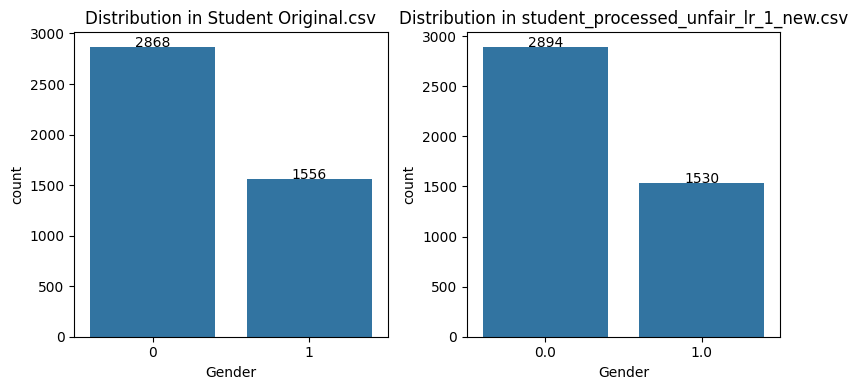

In [ ]:
# Create plots to compare the distribution of 'Gender' in StudentPerformance
plt.figure(figsize=(8, 4))

# First subplot: original dataset
plt.subplot(1, 2, 1)
ax1 = sns.countplot(data=stu_original, x='Gender')
plt.title('Distribution in Student Original.csv')

# Add counts on top of bars
for p in ax1.patches:
    count = int(p.get_height())
    ax1.text(p.get_x() + p.get_width() / 2., p.get_height() + 1,
             str(count), ha="center")

# Second subplot: unfair dataset
plt.subplot(1, 2, 2)
ax2 = sns.countplot(data=stu_unfair, x='Gender')
plt.title('Distribution in student_processed_unfair_lr_1_new.csv')

# Add counts on top of bars
for p in ax2.patches:
    count = int(p.get_height())
    ax2.text(p.get_x() + p.get_width() / 2., p.get_height() + 1,
             str(count), ha="center")

plt.tight_layout()
plt.show()

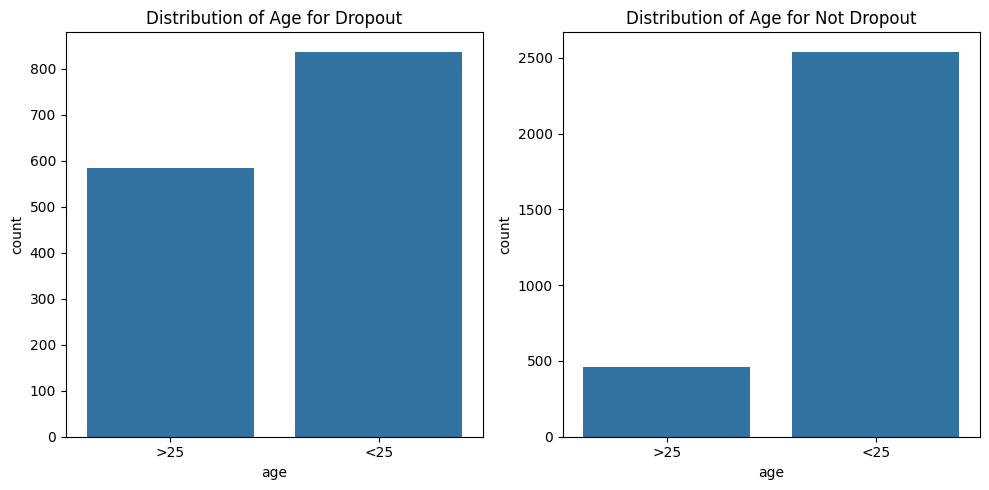

In [ ]:
# Show distribution of Gender by outcome for original datset

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=stu_original[stu_original['dropout'] == 0], x='age')
plt.title('Distribution of Age for Dropout')
plt.xticks([0, 1], ['>25', '<25'])

plt.subplot(1, 2, 2)
sns.countplot(data=stu_original[stu_original['dropout'] == 1], x='age')
plt.title('Distribution of Age for Not Dropout')
plt.xticks([0, 1], ['>25', '<25'])

plt.tight_layout()
plt.show()

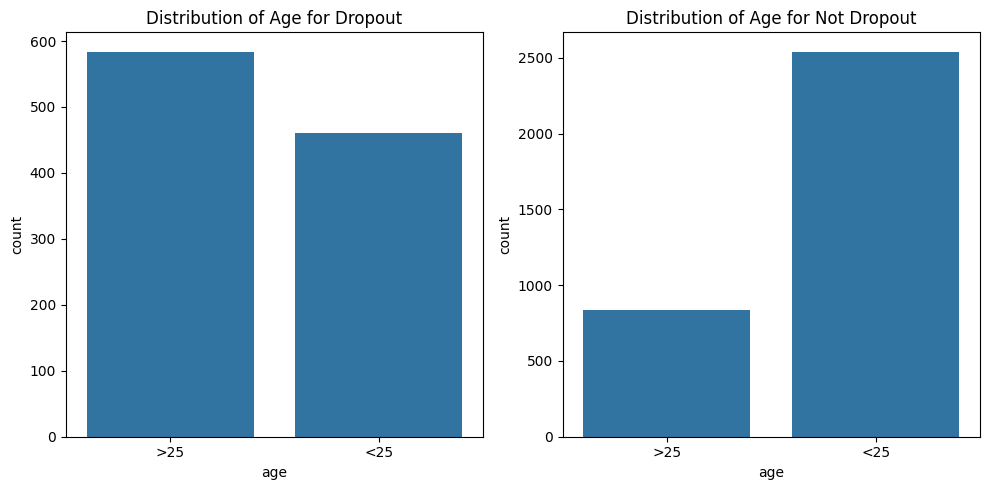

In [ ]:
# Show distribution of Gender by outcome for modified dataset

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=stu_unfair[stu_unfair['dropout'] == 0], x='age')
plt.title('Distribution of Age for Dropout')
plt.xticks([0, 1], ['>25', '<25'])

plt.subplot(1, 2, 2)
sns.countplot(data=stu_unfair[stu_unfair['dropout'] == 1], x='age')
plt.title('Distribution of Age for Not Dropout')
plt.xticks([0, 1], ['>25', '<25'])

plt.tight_layout()
plt.show()

# Other Functions

In [ ]:
# Define parameters for the genetic algorithm
# Choose values to experiment.

'''
** Unfairness Metrics Index **
1	overall accuracy equality
2	statistical parity
3	conditional procedure
4	conditional use accuracy equality
5	treatment equality
6	all equality
7	calibrated equality

'''
unfairness_metric_index = 2
dataset_filename = "adult_processed.csv"
label_column_name = "income"
sensitive_column_name = "sex"

# Genetic Algorithm Parameters
population_size_to_set = 1000   # Default is 100, try 50 or 200 as in the paper's experiments
mutation_rate_to_set = 0.002    # Default is 0.002, try 0.004 or 0.008 as in paper's experiments
iterations_to_set = 50          # Default is 50
selection_rate_to_set = 0.6     # Default is 0.6

In [ ]:
command = (
        f"python main.py --unfair_metric {unfairness_metric_index} "
        f"--dataset \"{dataset_filename}\" "
        f"--label_name \"{label_column_name}\" "
        f"--sensitive_name \"{sensitive_column_name}\" "
        f"--population_size {population_size_to_set} "
        f"--mutation_rate {mutation_rate_to_set} "
        f"--iterations {iterations_to_set} "
        f"--selection_rate {selection_rate_to_set} "
        f"--save_unfair_dataset"
    )

print(f"\nExecuting command:\n{command}\n")


Executing command:
python main.py --unfair_metric 2 --dataset "adult_processed.csv" --label_name "income" --sensitive_name "sex" --population_size 1000 --mutation_rate 0.002 --iterations 50 --selection_rate 0.6 --save_unfair_dataset



In [ ]:
# Execute the command
!{command}

usage: main.py [-h] [--generate_reference] [--dataset DATASET]
               [--unfair_metric UNFAIR_METRIC] [--label_name LABEL_NAME]
               [--sensitive_name SENSITIVE_NAME] [--save_unfair_dataset]
main.py: error: unrecognized arguments: --population_size 1000 --mutation_rate 0.002 --iterations 50 --selection_rate 0.6


In [ ]:
!git clone https://github.com/diogomatoschaves/geneal
%cd geneal

Cloning into 'geneal'...
remote: Enumerating objects: 645, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 645 (delta 64), reused 105 (delta 51), pack-reused 513 (from 1)
Receiving objects: 100% (645/645), 12.06 MiB | 19.36 MiB/s, done.
Resolving deltas: 100% (350/350), done.
/content/unfair_dataset_generation/geneal


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification

from typing import Sequence

import math

import datetime
import logging
import argparse

from abc import ABCMeta, abstractmethod

In [ ]:
from geneal.utils.exceptions import NoFitnessFunction, InvalidInput
from geneal.utils.exceptions_messages import exception_messages
from geneal.utils.helpers import get_elapsed_time
from geneal.utils.logger import configure_logger

ModuleNotFoundError: No module named 'geneal'

In [ ]:
def get_adult_data():
    """Download and preprocess the UCI Adult dataset"""
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                 'hours_per_week', 'native_country', 'income']

    df = pd.read_csv(url, header=None, names=col_names, na_values=" ?", skipinitialspace=True)
    df.dropna(inplace=True)

    # Binarize income
    df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

    # Binarize sex (Male=1, Female=0)
    df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)

    # Optional: Binarize race (White=1, Non-White=0)
    df['race'] = df['race'].apply(lambda x: 1 if x == 'White' else 0)

    return df

In [ ]:
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,1,1,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,1,1,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,1,1,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,0,1,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,0,0,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,1,0,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,1,1,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,1,0,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,1,1,0,0,20,United-States,0


In [ ]:
def generate_biased_data(df, sensitive_attr, sensitive_attr_value=1, target_label=1, drop_fraction=0.9):
    """
    Introduce bias by dropping a fraction of favorable instances from the privileged group.

    Args:
        df (pd.DataFrame): Original dataset
        sensitive_attr (str): Column name of the sensitive feature (e.g., 'sex')
        sensitive_attr_value (int): Value to consider privileged (e.g., 1 for Male)
        target_label (int): Label to suppress (e.g., 1 for income >50K)
        drop_fraction (float): Fraction of matching rows to drop

    Returns:
        pd.DataFrame: Biased dataset
    """
    mask = (df[sensitive_attr] == sensitive_attr_value) & (df['income'] == target_label)
    drop_indices = df[mask].sample(frac=drop_fraction, random_state=42).index
    df_biased = df.drop(index=drop_indices)
    return df_biased

In [ ]:
df = get_adult_data()
print("Original dataset shape:", df.shape)

# Inject bias: drop 90% of high-income males
biased_df = generate_biased_data(
    df.copy(),
    sensitive_attr='sex',
    sensitive_attr_value=1,  # 1 = Male
    target_label=1,          # 1 = income >50K
    drop_fraction=0.9
)

print("Biased dataset shape:", biased_df.shape)

# Distribution check
print("\nIncome by sex (biased):")
print(biased_df.groupby('sex')['income'].value_counts(normalize=True).unstack())

Original dataset shape: (32561, 15)
Biased dataset shape: (26565, 15)

Income by sex (biased):
income         0         1
sex                       
0       0.890539  0.109461
1       0.957832  0.042168


In [ ]:
def modify_bias(df, sensitive_attribute, target_variable, bias_level):
    """
    Modifies the dataset to introduce bias related to the sensitive attribute.

    Args:
        df (pd.DataFrame): The input DataFrame.
        sensitive_attribute (str): The name of the sensitive attribute column.
        target_variable (str): The name of the target variable column.
        bias_level (float): The amount of bias to introduce (e.g., 0.1 for 10% bias).

    Returns:
        pd.DataFrame: The modified DataFrame with added bias.
    """
    df_biased = df.copy() # create a copy to work with
    # ---  Adapt this part to match the logic from the original repository ---
    # Example (replace with actual logic from the unfair_dataset_generation repo):
    # 1. Identify groups based on the sensitive attribute.
    group1 = df_biased[df_biased[sensitive_attribute] == 0]
    group2 = df_biased[df_biased[sensitive_attribute] == 1]

    # 2. Modify the target variable probabilities based on the bias level.
    #    This is where you'll introduce the unfairness.
    num_to_change_group1 = int(len(group1) * bias_level)
    num_to_change_group2 = int(len(group2) * bias_level)

    # Example:  Make it more likely for group1 to have a negative outcome
    indices_to_change_group1 = np.random.choice(group1.index, size=num_to_change_group1, replace=False)
    df_biased.loc[indices_to_change_group1, target_variable] = 0  # Assuming 0 is the "negative" outcome

    indices_to_change_group2 = np.random.choice(group2.index, size=num_to_change_group2, replace=False)
    df_biased.loc[indices_to_change_group2, target_variable] = 1

    return df_biased


In [ ]:
bias_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]  # Example bias levels
biased_datasets = []

for bias_level in bias_levels:
    df_biased = modify_bias(df, 'sex', 'income', bias_level) # Replace with your names
    biased_datasets.append(df_biased)
    print(f"Generated dataset with bias level: {bias_level}")

# biased_datasets now contains a list of DataFrames, each with a different bias level.
# You can save these to CSV files, or use them for further analysis.
for i, biased_df in enumerate(biased_datasets):
    biased_df.to_csv(f'biased_data_{bias_levels[i] * 100}.csv', index=False)

Generated dataset with bias level: 0.0
Generated dataset with bias level: 0.1
Generated dataset with bias level: 0.2
Generated dataset with bias level: 0.3
Generated dataset with bias level: 0.4
Generated dataset with bias level: 0.5


In [ ]:
# show the distribution of income for both sex in all biased_dataset
for i, biased_df in enumerate(biased_datasets):
    print(f"Bias Level: {bias_levels[i] * 100}%")
    print(biased_df.groupby('sex')['income'].value_counts(normalize=True).unstack())

Bias Level: 0.0%
income         0         1
sex                       
0       0.890539  0.109461
1       0.694263  0.305737
Bias Level: 10.0%
income         0         1
sex                       
0       0.901495  0.098505
1       0.625608  0.374392
Bias Level: 20.0%
income         0         1
sex                       
0       0.912821  0.087179
1       0.555530  0.444470
Bias Level: 30.0%
income         0         1
sex                       
0       0.924798  0.075202
1       0.487517  0.512483
Bias Level: 40.0%
income         0         1
sex                       
0       0.930554  0.069446
1       0.417393  0.582607
Bias Level: 50.0%
income         0         1
sex                       
0       0.945223  0.054777
1       0.346719  0.653281


<ipython-input-30-930b8aee0929>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Sex')


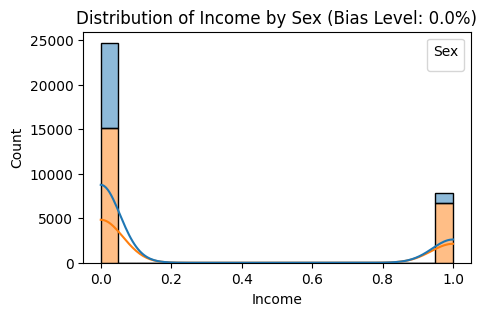

<ipython-input-30-930b8aee0929>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Sex')


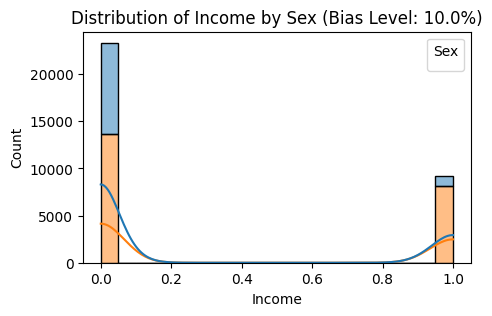

<ipython-input-30-930b8aee0929>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Sex')


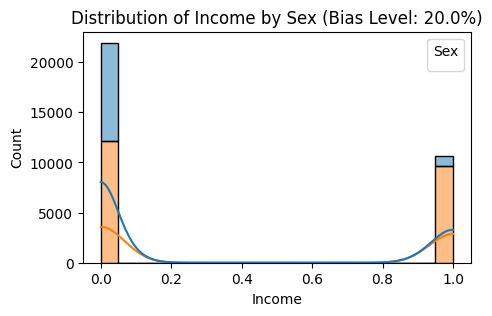

<ipython-input-30-930b8aee0929>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Sex')


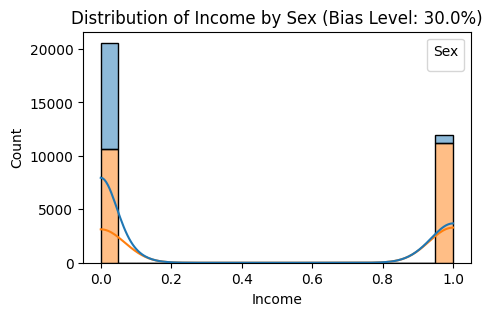

<ipython-input-30-930b8aee0929>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Sex')


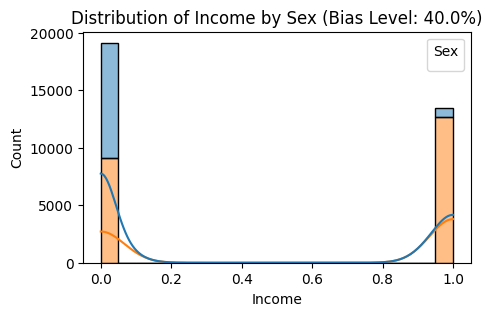

<ipython-input-30-930b8aee0929>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Sex')


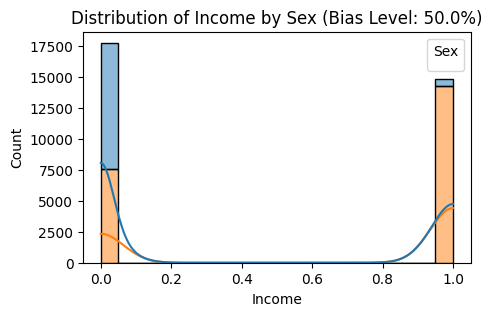

In [ ]:
# Plot the distribution of income for both sex in all biased_dataset
for i, biased_df in enumerate(biased_datasets):
    plt.figure(figsize=(5, 3))
    sns.histplot(data=biased_df, x='income', hue='sex', multiple='stack', bins=20, kde=True)
    plt.title(f'Distribution of Income by Sex (Bias Level: {bias_levels[i] * 100}%)')
    plt.xlabel('Income')
    plt.ylabel('Count')
    plt.legend(title='Sex')
    plt.show()


<ipython-input-6-5b6eeb62582e>:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='sex', y='income', data=biased_df, ci=None)


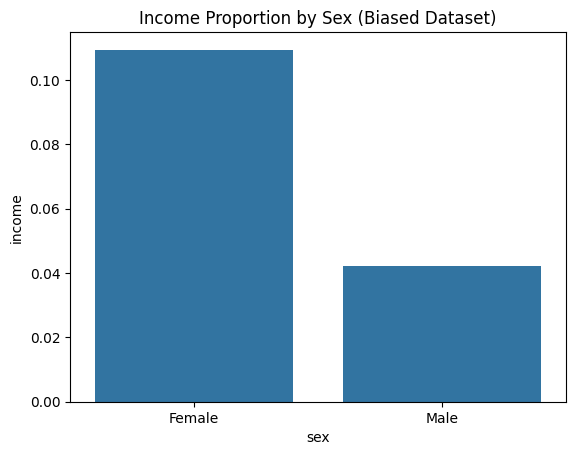

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='sex', y='income', data=biased_df, ci=None)
plt.title('Income Proportion by Sex (Biased Dataset)')
plt.xticks([0, 1], ['Female', 'Male'])
plt.show()

In [ ]:
allowed_selection_strategies = {"roulette_wheel", "two_by_two", "random", "tournament"}


class GenAlgSolver:
    def __init__(
        self,
        fitness_function=None,
        expect_score=None,
        max_gen: int = 1000,
        pop_size: int = 100,
        gene_mutation_rate: float = 0.5,
        mutation_rate: float = 0.15,
        selection_rate: float = 0.5,
        selection_strategy: str = "roulette_wheel",
        verbose: bool = True,
        show_stats: bool = True,
        plot_results: bool = True,
        excluded_genes: Sequence = None,
        n_crossover_points: int = 1,
        random_state: int = None,
    ):
        """
        :param fitness_function: can either be a fitness function or
        a class implementing a fitness function + methods to override
        the default ones: create_offspring, mutate_population, initialize_population
        :param n_genes: number of genes (variables) to have in each chromosome
        :param max_gen: maximum number of generations to perform the optimization
        :param pop_size: population size
        :param mutation_rate: rate at which random mutations occur
        :param selection_rate: percentage of the population to be selected for crossover
        :param selection_strategy: strategy to use for selection
        :param verbose: whether to print iterations status
        :param show_stats: whether to print stats at the end
        :param plot_results: whether to plot results of the run at the end
        :param n_crossover_points: number of slices to make for the crossover
        :param random_state: optional. whether the random seed should be set
        """

        if isinstance(random_state, int):
            np.random.seed(random_state)

        configure_logger()

        self.check_input_base(
            fitness_function, selection_strategy, pop_size, excluded_genes
        )

        self.selection_strategy = selection_strategy
        self.expect_score = expect_score
        self.max_gen = max_gen
        self.pop_size = pop_size
        self.gene_mutation_rate = gene_mutation_rate
        self.mutation_rate = mutation_rate
        self.selection_rate = selection_rate
        self.n_crossover_points = n_crossover_points
        self.verbose = verbose
        self.show_stats = show_stats
        self.plot_results = plot_results

        self.pop_keep = math.floor(selection_rate * pop_size)

        if self.pop_keep < 2:
            self.pop_keep = 2

        self.prob_intervals = self.get_selection_probabilities()

        self.n_matings = math.floor((self.pop_size - self.pop_keep) / 2)

        self.generations_ = 0
        self.best_individual_ = None
        self.best_fitness_ = 0
        self.population_ = None
        self.fitness_ = None

    def check_input_base(
        self, fitness_function, selection_strategy, pop_size, excluded_genes
    ):

        if not fitness_function:
            try:
                getattr(self, "fitness_function")
            except AttributeError:
                raise NoFitnessFunction(
                    "A fitness function must be defined or provided as an argument"
                )
        else:
            self.fitness_function = fitness_function

        if selection_strategy not in allowed_selection_strategies:
            raise InvalidInput(
                exception_messages["InvalidSelectionStrategy"](
                    selection_strategy, allowed_selection_strategies
                )
            )

        # if pop_size < 2:
        #     raise (InvalidInput(exception_messages["InvalidPopulationSize"]))

        if isinstance(excluded_genes, (list, tuple, np.ndarray)):
            self.allowed_mutation_genes = [
                item
                for item in self.allowed_mutation_genes
                if item not in excluded_genes
            ]

        elif excluded_genes is not None:
            raise InvalidInput(
                exception_messages["InvalidExcludedGenes"](excluded_genes)
            )

    def solve(self):
        """
        Performs the genetic algorithm optimization according to the parameters
        provided at initialization.

        :return: None
        """

        start_time = datetime.datetime.now()

        mean_fitness = np.ndarray(shape=(1, 0))
        max_fitness = np.ndarray(shape=(1, 0))

        # initialize the population
        population, labels, groups = self.initialize_population()
        self.n_mutations = self.get_number_mutations()
        fitness, coeff = self.calculate_fitness(population, labels, groups, 0, self.expect_score)
        fitness = [i[0] for i in fitness]
        fitness, population = self.sort_by_fitness(fitness, population)

        gen_interval = max(round(self.max_gen / 10), 1)
        last_unfair = fitness[0]
        gen_n = 0
        while True:
            if gen_n >= self.max_gen:
                break

            gen_n += 1

            if self.verbose and gen_n % gen_interval == 0:
                logging.info(f"Iteration: {gen_n}")
                logging.info(f"Best fitness: {fitness[0]}")

            mean_fitness = np.append(mean_fitness, fitness.mean())
            max_fitness = np.append(max_fitness, fitness[0])

            ma, pa = self.select_parents(fitness)
            ix = np.arange(0, self.pop_size - self.pop_keep - 1, 2)

            xp = np.array(
                list(map(lambda _: self.get_crossover_points(), range(self.n_matings)))
            )

            for i in range(xp.shape[0]):
                # create first offspring
                population[-1 - ix[i], :, :] = self.create_offspring(
                    population[ma[i], :], population[pa[i], :], xp[i], "first"
                )
                # create second offspring
                population[-1 - ix[i] - 1, :, :] = self.create_offspring(
                    population[pa[i], :], population[ma[i], :], xp[i], "second"
                )

            population = self.mutate_population(population, self.n_mutations)
            fitness, coeff = self.calculate_fitness(population, labels, groups, gen_n / self.max_gen, self.expect_score)
            fitness = np.hstack(([i[0] for i in fitness]))
            fitness, population = self.sort_by_fitness(fitness, population)

        self.generations_ = gen_n
        self.best_individual_ = population[0, :]
        self.best_fitness_ = fitness[0]
        self.population_ = population
        self.fitness_ = fitness

        if self.plot_results:
            self.plot_fitness_results(mean_fitness, max_fitness, gen_n)

        if self.show_stats:
            end_time = datetime.datetime.now()

            time_str = get_elapsed_time(start_time, end_time)

            self.print_stats(time_str)
        return pd.DataFrame(self.best_individual_, columns=self.feature), labels, groups

    def calculate_fitness(self, population, labels, groups, gen_percent, expect_score):
        """
        Calculates the fitness of the population

        :param population: population state at a given iteration
        :return: the fitness of the current population
        """
        return self.fitness_function(population, labels, groups, gen_percent, expect_score)

    def select_parents(self, fitness):
        """
        Selects the parents according to a given selection strategy.
        Options are:

        roulette_wheel: Selects individuals from mating pool giving
        higher probabilities to fitter individuals.

        two_by_two: Pairs fittest individuals two by two

        random: Selects individuals from mating pool randomly.

        tournament: Selects individuals by choosing groups of 3 candidate
        individuals and then selecting the fittest one from the 3.

        :param fitness: the fitness values of the population at a given iteration
        :return: a tuple containing the selected 2 parents for each mating
        """

        if self.selection_strategy == "roulette_wheel":

            ma = np.apply_along_axis(
                self.roulette_wheel_selection, 1, np.random.rand(self.n_matings, 1)
            )
            pa = np.apply_along_axis(
                self.roulette_wheel_selection, 1, np.random.rand(self.n_matings, 1)
            )

        elif self.selection_strategy == "two_by_two":

            range_max = int(self.n_matings * 2)
            ma = np.arange(range_max)[::2]
            pa = np.arange(range_max)[1::2]

            if ma.shape[0] > pa.shape[0]:
                ma = ma[:-1]

        elif self.selection_strategy == "random":

            ma = np.apply_along_axis(
                self.random_selection, 1, np.random.rand(self.n_matings, 1)
            )
            pa = np.apply_along_axis(
                self.random_selection, 1, np.random.rand(self.n_matings, 1)
            )

        elif self.selection_strategy == "tournament":

            range_max = int(self.n_matings * 2)

            ma = self.tournament_selection(fitness, range_max)
            pa = self.tournament_selection(fitness, range_max)

        return ma, pa

    def roulette_wheel_selection(self, value):
        """
        Performs roulette wheel selection

        :param value: random value defining which individual is selected
        :return: the selected individual
        """
        return np.argmin(value > self.prob_intervals) - 1

    def random_selection(self, value):
        """
        Performs random selection

        :param value: random value defining which individual is selected
        :return: the selected individual
        """
        return np.argmin(value > self.prob_intervals) - 1

    def tournament_selection(self, fitness, range_max):
        """
        Performs tournament selection.

        :param fitness: the fitness values of the population at a given iteration
        :param range_max: range of individuals that can be selected for the tournament
        :return: the selected individuals
        """

        selected_individuals = np.random.choice(range_max, size=(self.n_matings, 3))

        return np.array(
            list(
                map(
                    lambda x: self.tournament_selection_helper(x, fitness),
                    selected_individuals,
                )
            )
        )

    @staticmethod
    def tournament_selection_helper(selected_individuals, fitness):
        """
        Helper for tournament selection method. Selects the fittest individual
        from a pool of candidate individuals

        :param selected_individuals: group of candidate individuals for
        tournament selection
        :param fitness: the fitness values of the population at a given iteration
        :return: the selected individual
        """

        individuals_fitness = fitness[selected_individuals]

        return selected_individuals[np.argmax(individuals_fitness)]

    def get_selection_probabilities(self):

        if self.selection_strategy == "roulette_wheel":

            mating_prob = (
                np.arange(1, self.pop_keep + 1) / np.arange(1, self.pop_keep + 1).sum()
            )[::-1]

            return np.array([0, *np.cumsum(mating_prob[: self.pop_keep + 1])])

        elif self.selection_strategy == "random":
            return np.linspace(0, 1, self.pop_keep + 1)

    # def get_number_mutations(self):
    #     return math.ceil((self.pop_size - 1) * self.n_genes * self.mutation_rate)

    @staticmethod
    def sort_by_fitness(fitness, population):
        """
        Sorts the population by its fitness.

        :param fitness: fitness of the population
        :param population: population state at a given iteration
        :return: the sorted fitness array and sorted population array
        """
        sorted_fitness = np.argsort(fitness)[::-1]
        population = population[sorted_fitness, :, :]
        fitness = np.array(fitness)[sorted_fitness]
        return fitness, population

    def get_crossover_points(self):
        """
        Retrieves random crossover points

        :return: a numpy array with the crossover points
        """
        return np.sort(
            np.random.choice(
                np.arange(self.n_persons + 1), self.n_crossover_points, replace=False
            )
        )

    def get_number_mutations(self):
        return math.ceil((self.pop_size * 0.9) * self.n_persons * self.n_genes * self.mutation_rate)

    @staticmethod
    def plot_fitness_results(mean_fitness, max_fitness, iterations):
        """
        Plots the evolution of the mean and max fitness of the population

        :param mean_fitness: mean fitness array for each generation
        :param max_fitness: max fitness array for each generation
        :param iterations: total number of generations
        :return: None
        """

        plt.figure(figsize=(7, 7))

        x = np.arange(1, iterations + 1)

        plt.plot(x, mean_fitness, label="mean fitness")
        plt.plot(x, max_fitness, label="max fitness")

        plt.legend()
        plt.show()

    def print_stats(self, time_str):
        """
        Prints the statistics of the optimization run

        :param time_str: time string given by the method get_elapsed_time
        :return: None
        """

        logging.info("\n#############################")
        logging.info("#\t\t\tSTATS\t\t\t#")
        logging.info("#############################\n\n")
        logging.info(f"Total running time: {time_str}\n\n")
        logging.info(f"Population size: {self.pop_size}")
        logging.info(f"Number variables: {self.n_genes}")
        logging.info(f"Selection rate: {self.selection_rate}")
        logging.info(f"Mutation rate: {self.mutation_rate}")
        logging.info(f"Number Generations: {self.generations_}\n")
        logging.info(f"Best fitness: {self.best_fitness_}")
        logging.info(f"Best individual: \n{pd.DataFrame(self.best_individual_, columns=self.feature)}")

    @abstractmethod
    def initialize_population(self):
        """
        Initializes the population of the problem. To be implemented in each child class.

        :return: a numpy array with a randomized initialized population
        """
        pass

    @staticmethod
    @abstractmethod
    def create_offspring(first_parent, sec_parent, crossover_pt, offspring_number):
        """
        Creates an offspring from 2 parents. It uses the crossover point(s)
        to determine how to perform the crossover. To be implemented on each child class.

        :param first_parent: first parent's chromosome
        :param sec_parent: second parent's chromosome
        :param crossover_pt: point(s) at which to perform the crossover
        :param offspring_number: whether it's the first or second offspring from a pair of parents.
        Important if there's different logic to be applied to each case.
        :return: the resulting offspring.
        """
        pass

    def mutate_population(self, population, n_mutations):
        """
        Mutates the population according to a given user defined rule.
        To be defined further in each child class. Each direct child class can call
        this super method to retrieve the mutation rows and mutations columns

        :param population: the population at a given iteration
        :param n_mutations: number of mutations to be performed. This number is
        calculated according to mutation_rate, but can be adjusted as needed inside this function
        :return: an array with the mutation_rows and mutation_cols
        """
        mutation_rows = np.random.choice(
            np.arange(int(self.pop_size * 0.1), self.pop_size), n_mutations, replace=True
        )

        mutation_cols = np.random.choice(
            self.n_genes, n_mutations, replace=True
        )

        mutation_persons = np.random.choice(
            self.n_persons, n_mutations, replace=True
        )
        return mutation_rows,  mutation_persons, mutation_cols

In [ ]:
class ContinuousGenAlgSolver(GenAlgSolver):
    def __init__(
        self,
        fitness_function=None,
        expect_score=None,
        path=None,
        dataset=None,
        labels=None,
        group_col=None,
        feature_name=None,
        max_gen: int = 1000,
        pop_size: int = 100,
        gene_mutation_rate: float = 0.5,
        mutation_rate: float = 0.15,
        selection_rate: float = 0.5,
        selection_strategy: str = "roulette_wheel",
        verbose: bool = True,
        show_stats: bool = True,
        plot_results: bool = True,
        excluded_genes: Sequence = None,
        variables_limits=(-10, 10),
        problem_type=float,
        n_crossover_points: int = 1,
        random_state: int = None
    ):
        """
        :param fitness_function: can either be a fitness function or
        a class implementing a fitness function + methods to override
        the default ones: create_offspring, mutate_population, initialize_population
        :param n_genes: number of genes (variables) to have in each chromosome
        :param max_gen: maximum number of generations to perform the optimization
        :param pop_size: population size
        :param mutation_rate: rate at which random mutations occur
        :param selection_rate: percentage of the population to be selected for crossover
        :param selection_strategy: strategy to use for selection
        :param verbose: whether to print iterations status
        :param show_stats: whether to print stats at the end
        :param plot_results: whether to plot results of the run at the end
        :param variables_limits: limits for each variable [(x1_min, x1_max), (x2_min, x2_max), ...].
        If only one tuple is provided, then it is assumed the same for every variable
        :param problem_type: whether problem is of float or integer type
        """

        GenAlgSolver.__init__(
            self,
            fitness_function=fitness_function,
            expect_score=expect_score,
            max_gen=max_gen,
            pop_size=pop_size,
            gene_mutation_rate=gene_mutation_rate,
            mutation_rate=mutation_rate,
            selection_rate=selection_rate,
            selection_strategy=selection_strategy,
            verbose=verbose,
            show_stats=show_stats,
            plot_results=plot_results,
            excluded_genes=excluded_genes,
            n_crossover_points=n_crossover_points,
            random_state=random_state,
        )

        # if not variables_limits:
        #     min_max = np.iinfo(np.int64)
        #     variables_limits = [(min_max.min, min_max.max) for _ in range(n_genes)]
        #
        # if get_input_dimensions(variables_limits) == 1:
        #     variables_limits = [variables_limits for _ in range(n_genes)]

        self.variables_limits = variables_limits
        self.path = path
        self.dataset = dataset
        self.labels = labels
        self.group_col = group_col
        self.feature_name = feature_name
        self.problem_type = problem_type

    def initialize_population(self, median_split=True):
        """
        Initializes the population of the problem according to the
        population size and number of genes and according to the problem
        type (either integers or floats).

        :return: a numpy array with a randomized initialized population
        """
        ori_p, ori_labels, ori_group, columns = self.dataset, self.labels, self.group_col, self.feature_name

        self.feature = columns

        n_person, n_genes = ori_p.shape
        self.ori_data = ori_p
        self.n_persons = n_person
        self.n_genes = n_genes
        n_mutation = math.ceil(self.gene_mutation_rate * n_person)
        n_gen = self.pop_size
        all_population = [self.dataset]
        for g in range(n_gen-1):
            modify = np.copy(ori_p)
            for i in range(ori_p.shape[1]):
                mutation_genes = np.random.choice(
                    np.arange(n_person), n_mutation, replace=False
                )
                assign_num = np.random.choice(
                    ori_p.iloc[:, i], n_mutation, replace=True
                )
                modify[mutation_genes, i] = assign_num
            all_population.append(modify)
        all_population = np.stack(all_population, axis=0)

        return all_population, ori_labels, ori_group

    def simulate_population(self, population):
        all_population = []
        n_gen, n_person, n_genes = population.shape
        for i in range(n_genes):
            features = np.random.choice(
                self.ori_data.iloc[:, i], n_person * n_gen, replace=True
            )
            all_population.append(features)

        all_population = np.stack(all_population, axis=1)
        all_population = all_population.reshape(n_gen, n_person, n_genes)
        return all_population

    def get_crossover_points(self):
        """
        Retrieves random crossover points

        :return: a numpy array with the crossover points
        """

        return np.sort(
            np.random.choice(
                np.arange(self.n_persons), self.n_crossover_points, replace=False
            )
        )

    def create_offspring(
        self, first_parent, sec_parent, crossover_pt, offspring_number
    ):
        """
        Creates an offspring from 2 parents. It performs the crossover
        :param first_parent: first parent's chromosome
        :param sec_parent: second parent's chromosome
        :param crossover_pt: row(s) at which to perform the crossover
        :param offspring_number: whether it's the first or second offspring from a pair of parents.
        Important if there's different logic to be applied to each case.
        :return: the resulting offspring.
        """
        crossover_pt = crossover_pt[0]

        return np.vstack(
            (first_parent[:crossover_pt, :], sec_parent[crossover_pt:, :])
        )

    def mutate_population(self, population, n_mutations):
        """
        Mutates the population by randomizing specific positions of the
        population individuals.

        :param population: the population at a given iteration
        :param n_mutations: number of mutations to be performed.
        :return: the mutated population
        """

        mutation_rows, mutation_persons, mutation_cols = super(
            ContinuousGenAlgSolver, self
        ).mutate_population(population, n_mutations)

        population[mutation_rows, mutation_persons, mutation_cols] = self.simulate_population(population)[
            mutation_rows, mutation_persons, mutation_cols
        ]
        return population

In [ ]:
class calculation():
    def __init__(self, dataset, labels, groups, index, groupkfold=None):
        self.data = dataset
        self.labels = labels
        self.groups = groups
        self.groupkfold = groupkfold
        self.unfair_index = index
        self.last_unfair = 0
        self.iter = 1
        self.inital_lr = self.initial_calculate(dataset, linear_model.LogisticRegression(max_iter=200, random_state=11798))
        self.inital_rf = self.initial_calculate(dataset, ensemble.RandomForestClassifier(random_state=11798))
        self.inital_et = self.initial_calculate(dataset, ensemble.ExtraTreesClassifier(random_state=11798))

    def initial_calculate(self, dataset, clf):
        if self.groupkfold is None:
            xval = model_selection.KFold(4, shuffle=True, random_state=11798)
        else:
            xval = model_selection.GroupKFold(4)
        # clf = linear_model.LogisticRegression(max_iter=200, random_state=11798)
        # clf = ensemble.RandomForestClassifier(random_state=11798)

        scoring = {}
        for m in unfairness_metrics.UNFAIRNESS_METRICS:
            if m == "calibration":
                metric = unfairness_metrics.UnfairnessMetric(pd.Series(self.groups), m)
                scoring[m] = metrics.make_scorer(metric, needs_proba=True)
            else:
                metric = unfairness_metrics.UnfairnessMetric(pd.Series(self.groups), m)
                scoring[m] = metrics.make_scorer(metric)
        scoring['auc'] = metrics.make_scorer(metrics.roc_auc_score)
        scoring['acc'] = metrics.make_scorer(metrics.accuracy_score)
        pipe = pipeline.Pipeline([
            ('standardize', preprocessing.StandardScaler()),
            ('model', clf)
        ])
        if self.groupkfold is None:
            result = model_selection.cross_validate(pipe, dataset, pd.Series(self.labels), verbose=0, cv=xval,
                                                    scoring=scoring
                                                    , return_estimator=True)
        else:
            result = model_selection.cross_validate(pipe, dataset, pd.Series(self.labels), verbose=0,
                                                    cv=xval, groups=self.groupkfold,
                                                    scoring=scoring
                                                    , return_estimator=True)
        unfair_score = []
        unfair_score.append(result['test_' + unfairness_metrics.UNFAIRNESS_METRICS[self.unfair_index]].mean())
        unfair_score.append(result['test_auc'].mean())
        unfair_score.append(result['test_acc'].mean())
        print('UNFAIRNESS SCORE: ', unfair_score)
        return unfair_score[0]

    def calculate_corr(self, dataset):
        corr = np.corrcoef(dataset.T)
        pos = np.where(np.abs(corr) > 0.4)
        return pos, corr[pos]

    def fit_scores(self, population, labels, idx_groups, gen_percent, expect_score, pnt=False):

        score, unfair_scores = [], []
        for i in range(population.shape[0]):
            self.coeff = 1
            if self.groupkfold is not None:
                xval = model_selection.GroupKFold(4)
            else:
                xval = model_selection.KFold(4, shuffle=True, random_state=11798)

            clf = linear_model.LogisticRegression(max_iter=200, random_state=11798)
            # clf = ensemble.RandomForestClassifier(random_state=11798)
            # clf = ensemble.ExtraTreesClassifier(random_state=11798)
            sml = np.count_nonzero(np.equal(self.data, population[i]) == 1) / (self.data.shape[0]*self.data.shape[1])

            scoring = {}
            for m in unfairness_metrics.UNFAIRNESS_METRICS:
                if m == "calibration":
                    metric = unfairness_metrics.UnfairnessMetric(pd.Series(self.groups), m)
                    scoring[m] = metrics.make_scorer(metric, needs_proba=True)
                else:
                    metric = unfairness_metrics.UnfairnessMetric(pd.Series(self.groups), m)
                    scoring[m] = metrics.make_scorer(metric)
            scoring['auc'] = metrics.make_scorer(metrics.roc_auc_score)
            scoring['acc'] = metrics.make_scorer(metrics.accuracy_score)

            pipe = pipeline.Pipeline([
                ('standardize', preprocessing.StandardScaler()),
                ('model', clf),
            ])

            if self.groupkfold is not None:
                result = model_selection.cross_validate(pipe, population[i], pd.Series(labels), verbose=0,
                                                        cv=xval, groups=self.groupkfold,
                                                        scoring=scoring
                                                        , return_estimator=True)
            else:
                result = model_selection.cross_validate(pipe, population[i], pd.Series(labels), verbose=0,
                                                        cv=xval,
                                                        scoring=scoring
                                                        , return_estimator=True)
            unfair_score = []

            for id_unfair in range(len(unfairness_metrics.UNFAIRNESS_METRICS)):
                if id_unfair == self.unfair_index:
                    unfair_score.append(result['test_'+unfairness_metrics.UNFAIRNESS_METRICS[id_unfair]].mean())
            unfair_score.append(result['test_auc'].mean())
            unfair_score.append(result['test_acc'].mean())
            if pnt:
                print(unfair_score)
            unfair_scores.append(unfair_score[0])
            score.append([sml, unfair_score[0]])

        n_top_10 = int(len(unfair_scores) * 0.1)

        # adjust weight
        if sum(unfair_scores[:n_top_10])/n_top_10 < expect_score:
            if gen_percent > 1 - (expect_score - sum(unfair_scores[:n_top_10])/n_top_10) / (expect_score - self.inital_lr):
                current_lr = sum(unfair_scores[:n_top_10]) / n_top_10
                current_percent = (current_lr - self.inital_lr)/(expect_score - self.inital_lr)
                self.coeff = gen_percent - current_percent + 1

        for i_scores in range(len(score)):
            score[i_scores].insert(0, self.coeff*4*score[i_scores][1] + score[i_scores][0])

        return score, self.coeff

    def post_evaluate(self, population, labels, group, clf):
        if self.groupkfold is not None:
            xval = model_selection.GroupKFold(4)
        else:
            xval = model_selection.KFold(4, shuffle=True, random_state=11798)

        groups_syn = group
        scoring = {}
        for m in unfairness_metrics.UNFAIRNESS_METRICS:
            if m == "calibration":
                metric = unfairness_metrics.UnfairnessMetric(pd.Series(groups_syn), m)
                scoring[m] = metrics.make_scorer(metric, needs_proba=True)
            else:
                metric = unfairness_metrics.UnfairnessMetric(pd.Series(groups_syn), m)
                scoring[m] = metrics.make_scorer(metric)
        scoring['auc'] = metrics.make_scorer(metrics.roc_auc_score)
        scoring['acc'] = metrics.make_scorer(metrics.accuracy_score)

        pipe = pipeline.Pipeline([
            ('standardize', preprocessing.StandardScaler()),
            ('model', clf),
        ])
        if self.groupkfold is not None:
            result = model_selection.cross_validate(pipe, population, pd.Series(labels), verbose=0,
                                                    cv=xval, groups=self.groupkfold,
                                                    scoring=scoring
                                                    , return_estimator=True)
        else:
            result = model_selection.cross_validate(pipe, population, pd.Series(labels), verbose=0,
                                                    cv=xval,
                                                    scoring=scoring
                                                    , return_estimator=True)

        unfair_score = []
        unfair_score.append(result['test_' + unfairness_metrics.UNFAIRNESS_METRICS[self.unfair_index]].mean())
        unfair_score.append(result['test_auc'].mean())
        unfair_score.append(result['test_acc'].mean())
        print('UNFAIRNESS SCORE: ', unfair_score)
        print('PERCENTAGE SAME: ', np.count_nonzero(np.equal(self.data, population) == 1) / (self.data.shape[0]*self.data.shape[1]))
        self.last_unfair = unfair_score[0]

        c = 0
        scores = []
        if self.groupkfold is not None:
            for train_index, test_index in xval.split(self.data, groups=self.groupkfold):
                # X_test, y_test = self.data[test_index], self.labels[test_index]
                X_test, y_test = self.data.iloc[test_index], self.labels.iloc[test_index]
                pred = result['estimator'][c].predict(X_test)
                scores.append(metrics.roc_auc_score(y_test, pred))
        else:
            for train_index, test_index in xval.split(self.data):
                # X_test, y_test = self.data[test_index], self.labels[test_index]
                X_test, y_test = self.data.loc[test_index], self.labels.loc[test_index]
                pred = result['estimator'][c].predict(X_test)
                scores.append(metrics.roc_auc_score(y_test, pred))
                c += 1
        self.score = sum(scores)/len(scores)
        print('AUC ON ORIGINAL DATASET: ', sum(scores)/len(scores))
        return unfair_score[0]


In [ ]:
import pandas as pd
from sklearn import metrics
import numpy as np
from collections import defaultdict
from statistics import mean


UNFAIRNESS_METRICS = ['overall_accuracy_equality', 'statistical_parity', 'conditional_procedure',
                      'conditional_use_accuracy_equality', 'treatment_equality', 'all_equality', 'calibration']


def stat_score(truth, predict):
    return np.count_nonzero(predict)/len(predict)


def sigmoid(x):
    return (1 / (1 + np.exp(-x+1)))-0.5


def treatment_score(truth, predict):
    """
    when one of the number of false positive and false negative is 0, the other is not 0,
    directly set treatment_score as 1.
    when both of the number of false positive and false negative are 0, directly set treatment_score as 0.
    otherwise, using sigmoid function to get the treatment_score.
    """
    fp_fn_index = truth != predict
    fp_fn_sum = np.count_nonzero(fp_fn_index)
    fp_fn = predict[fp_fn_index]
    fp_sum = np.count_nonzero(fp_fn)
    fn_sum = (fp_fn_sum-fp_sum)
    if fp_sum == fn_sum:
        return 0
    elif [fp_sum, fn_sum].count(0) == 1:
        return 1
    else:
        return sigmoid(max(fp_sum/fn_sum, fn_sum/fp_sum))


def cal_score(y_true, y_pred):
    """Calculate a calibration score (CAL) for a model's predictions. Calculate true vs. predicted
    probability for overlapping bins of 100 instances, sorted by predicted probability.

    Caruana, R., & Niculescu-Mizil, A. (2004). Data mining in metric space: An empirical analysis of
    supervised learning performance criteria. In Proceedings of the Tenth ACM SIGKDD International
    Conference on Knowledge Discovery and Data Mining, 69–78.
    https://doi.org/10.1145/1014052.1014063

    Args:
        y_true (iterable): Binary truth values (1 or 0)
        y_pred (iterable): Predicted probability of the positive class

    Returns:
        float: CAL score (0 to 1 where 1 is better calibration)
    """
    y_pred, y_true = zip(*sorted(zip(y_pred, y_true)))  # Sort both by prediction
    cal = []
    bins = int(len(y_pred) * 0.2)
    for i in range(len(y_true) - bins):
        pred_bin = np.mean(y_pred[i:i + bins+1])
        true_bin = np.mean(y_true[i:i + bins+1])
        cal.append(abs(pred_bin - true_bin))
    return np.mean(cal)


def calc_unfairness(y_true, y_pred, protected_groups, unfairness_metric):
    """Overall accuracy equality metric. Measures the maximum difference between accuracy
    (proportion correct) for each protected group. From https://arxiv.org/pdf/1703.09207.pdf, though
    note that this version allows for more than 2 classes and more than 2 protected groups. Multiple
    protected groups are handled by taking the maximum difference between each pair of protected
    groups as the unfairness measure, under the (arguable) assumption that people are most concerned
    with the worst-case scenario.

    Args:
        y_true (array-like): True classification labels, represented as integers
        y_pred (array-like): Predicted classification labels, represented as integers
        protected_groups (pd.Series): Group membership of each person/instance

    Returns:
        float: Unfairness measure in [0, 1], where 0 means perfect fairness
    """
    measurements = defaultdict(list)
    for group in protected_groups.unique():
        group_mask = protected_groups == group
        if unfairness_metric == 'overall_accuracy_equality':
            measurement = metrics.accuracy_score(y_true[group_mask], y_pred[group_mask])
        elif unfairness_metric == 'statistical_parity':
            measurement = stat_score(y_true[group_mask], y_pred[group_mask])
        elif unfairness_metric == 'conditional_procedure':
            measurement = metrics.recall_score(y_true[group_mask], y_pred[group_mask],
                                               zero_division=0)
        elif unfairness_metric == 'conditional_use_accuracy_equality':
            measurement = metrics.precision_score(y_true[group_mask], y_pred[group_mask],
                                                  zero_division=0)
        elif unfairness_metric == 'treatment_equality':
            measurement = treatment_score(y_true[group_mask], y_pred[group_mask])
        elif unfairness_metric == 'calibration':
            measurement = cal_score(y_true[group_mask], y_pred[group_mask])
        else:
            measurement = metrics.accuracy_score(y_true[group_mask], y_pred[group_mask])
            measurements['overall_accuracy_equality'].append(measurement)
            measurement = stat_score(y_true[group_mask], y_pred[group_mask])
            measurements['statistical_parity'].append(measurement)
            measurement = metrics.recall_score(y_true[group_mask], y_pred[group_mask],
                                               zero_division=0)
            measurements['conditional_procedure'].append(measurement)
            measurement = metrics.precision_score(y_true[group_mask], y_pred[group_mask],
                                                  zero_division=0)
            measurements['conditional_use_accuracy_equality'].append(measurement)
            measurement = treatment_score(y_true[group_mask], y_pred[group_mask])
            measurements['treatment_equality'].append(measurement)
            continue
        measurements[unfairness_metric].append(measurement)

    measurements[unfairness_metric] = [max(measurements[i]) - min(measurements[i]) for i in measurements]
    if unfairness_metric == 'all_equality':
        return mean(measurements[unfairness_metric])
    else:
        return measurements[unfairness_metric][0]


class UnfairnessMetric():
    def __init__(self, protected_groups, unfairness_metric):
        """Unfairness metric that can be used with scikit-learn functionality; e.g., in a Pipeline.
        `protected_groups` must be specified in advance so that it can be used later, since
        scikit-learn does not allow for passing in custom values during cross-validation splitting.

        Args:
            protected_groups (pd.Series): Group membership of each person/instance
            unfairness_metric (str): Name of unfairness metric
        """
        assert isinstance(protected_groups, pd.Series), 'pd.Series required for index matching'
        self.protected_groups = protected_groups
        self.unfairness_metric = unfairness_metric
        self.__name__ = 'UnfairnessMetric'

    def __call__(self, y_true, y_pred):
        assert isinstance(y_true, pd.Series), 'pd.Series required for index matching'
        test_groups = self.protected_groups.loc[y_true.index]
        return calc_unfairness(y_true, y_pred, test_groups, self.unfairness_metric)


class CombinedMetric():
    def __init__(self, accuracy_metric_func, protected_groups, unfairness_metric,
                 unfairness_weight=1.0):
        """Creates a combined unfairness and accuracy metric that can be used with sciki-learn
        functionality; e.g., in a Pipeline. `protected_groups` must be specified in advance so that
        it can be used later, since scikit-learn does not allow for passing in custom values during
        cross-validation splitting.

        The resulting metric will subtract unfairness from accuracy.

        Args:
            accuracy_metric_func (function): E.g., `sklearn.metrics.accuracy_score`
            protected_groups (pd.Series): Group membership of each person/instance
            unfairness_metric (str): Name of unfairness metric
            unfairness_weight (float): How to weight unfairness in the calculation; [0, inf]
        """
        assert isinstance(protected_groups, pd.Series), 'pd.Series required for index matching'
        self.accuracy_metric_func = accuracy_metric_func
        self.protected_groups = protected_groups
        self.unfairness_metric = unfairness_metric
        self.unfairness_weight = unfairness_weight
        self.__name__ = 'CombinedMetric'

    def __call__(self, y_true, y_pred):
        assert isinstance(y_true, pd.Series), 'pd.Series required for index matching'
        test_groups = self.protected_groups.loc[y_true.index]
        unfairness = calc_unfairness(y_true, y_pred, test_groups, self.unfairness_metric)
        return self.accuracy_metric_func(y_true, y_pred) - unfairness * self.unfairness_weight


if __name__ == '__main__':
    b = [1, 1, 1, 1, 1, 1, 1]
    a = [0, 0.1, 0.13, 0.2, 0.5, 0.8, 1.0]
    print(np.array([b, a]).max(axis=1))
    # cal_score(b, a)
    # accuracy measure fairness
    # v = CombinedMetric(metrics.accuracy_score, pd.Series([0, 1, 1]), 'treatment_equality')
    # score = v(pd.Series([0, 1, 1]), pd.Series([0, 0, 1]))
    #
    # from sklearn import datasets, naive_bayes, model_selection
    # import numpy as np
    # np.random.seed(11798)
    # from dataset_loader import get_simulated_data
    # ds = get_simulated_data()
    # y = pd.Series(ds['labels'])
    # protected_groups = pd.Series(ds['data']['group'])
    # # X = ds['data'][['fair_feature', 'unfair_feature']]
    # X = np.array(ds['data']['unfair_feature']).reshape(-1, 1)
    #
    # # X, y = datasets.load_iris(return_X_y=True)
    # # y = pd.Series(y)
    # # # Since there are systematic biases in per-class accuracy, treating each class as a protected
    # # # group lowers the score
    # # protected_groups = pd.Series(y)
    # # Conversely, randomly generating the protected groups has little effect (as expected)
    # # protected_groups = pd.Series(np.random.randint(0, 2, len(y)))
    # clf = naive_bayes.GaussianNB()
    # cm = CombinedMetric(metrics.accuracy_score, protected_groups, 'all_equality', 1)
    # scoring = metrics.make_scorer(cm)
    # cross_val = model_selection.KFold(4, shuffle=True)
    # scores = model_selection.cross_val_score(clf, X, y, cv=cross_val, scoring=scoring)
    # print(scores)

In [ ]:
def load_ori_population(path, sensitive_name, label):
    file = pd.read_csv("datasets/"+path, header=0)
    labels = file[label]
    group_col = file.loc[:, sensitive_name]
    feature_name = list([i for i in file.columns if i not in [sensitive_name, label]])
    population = file[feature_name]
    return population, labels, group_col, feature_name


def simulate_dataset(sensitive_name, label_name):
    population, labels = make_classification(n_samples=1000, n_features=16, n_informative=10,
                                             flip_y=0.2, random_state=15368)

    population[:, 6:11] = np.abs(np.floor(population[:, 6:11]))
    population[:, :6] = np.round(1/(1 + np.exp(-population[:, :6])))
    population = pd.DataFrame(population)
    population[label_name] = labels
    population = population.rename(columns={0: sensitive_name})
    population.to_csv("datasets/simulated.csv", index=False)
    print("The reference dataset saved to datasets/simulated.csv.")
    return population

In [ ]:
def run(datafile, metric, sensitive_name, label):
    dataset, labels, groups, _ = load_ori_population(datafile, sensitive_name, label)
    fitness_function = calculation(dataset, labels, groups, metric)

    solver = ContinuousGenAlgSolver(
        fitness_function=fitness_function.fit_scores,
        expect_score=0.5,
        dataset=dataset, labels=labels, group_col=groups, feature_name=_,
        pop_size=100,  # population size (number of individuals)
        max_gen=50,  # maximum number of generations
        gene_mutation_rate=0.002,
        mutation_rate=0.002,  # mutation rate to apply to the population
        selection_rate=0.6,  # percentage of the population to select for mating
        selection_strategy="roulette_wheel",  # strategy to use for selection. see below for more details
        plot_results=False,
        random_state=98958
    )

    population, labels, group = solver.solve()
    unfair_lr = fitness_function.post_evaluate(population, labels, group, linear_model.LogisticRegression(max_iter=200, random_state=11798))
    unfair_rf = fitness_function.post_evaluate(population, labels, group, ensemble.RandomForestClassifier(random_state=11798))
    unfair_et = fitness_function.post_evaluate(population, labels, group, ensemble.ExtraTreesClassifier(random_state=11798))

    print("DIFFERENCE LOGISTICREGRESSION:", unfair_lr-fitness_function.inital_lr)
    print("DIFFERENCE RANDOMFOREST:", unfair_rf-fitness_function.inital_rf)
    print("DIFFERENCE EXTATREE:", unfair_et-fitness_function.inital_et)
    return population, labels, group

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(
        description="simulated dataset"
    )
    parser.add_argument('--generate_reference', action="store_true")

    parser.add_argument('--dataset', default="simulated.csv", type=str)
    parser.add_argument('--unfair_metric', help="overall_accuracy_equality, statistical_parity, conditional_procedure,\
                      conditional_use_accuracy_equality, treatment_equality, all_equality, calibration", type=int,
                        default=7)
    parser.add_argument('--label_name', help="name of prediction", default='label')
    parser.add_argument('--sensitive_name', help="name of sensitive feature", default='protected')
    parser.add_argument('--save_unfair_dataset', help="add argument to save simulated unfair dataset", action="store_true", default=1)

    args = parser.parse_args()

    print(args)
    datafile = args.dataset
    u_metric_index = args.unfair_metric-1
    label_name = args.label_name
    sensitive_name = args.sensitive_name

    if args.generate_reference:
        print("Generating a reference dataset.")
        simulate_dataset(sensitive_name, label_name)
    else:
        print(datafile, unfairness_metrics.UNFAIRNESS_METRICS[u_metric_index])

        population, group, labels = run(datafile, u_metric_index, sensitive_name, label_name)

        if args.save_unfair_dataset:
            population[sensitive_name] = group
            population[label_name] = labels
            population.to_csv("datasets/"+datafile.split('.')[0] + '_unfair_lr_' + str(u_metric_index) + '.csv',
                              index=False)
            print("Unfair dataset saved to " + "datasets/"+datafile.split('.')[0] + '_unfair_lr_' + str(u_metric_index) + '.csv')

usage: colab_kernel_launcher.py [-h] [--generate_reference]
                                [--dataset DATASET]
                                [--unfair_metric UNFAIR_METRIC]
                                [--label_name LABEL_NAME]
                                [--sensitive_name SENSITIVE_NAME]
                                [--save_unfair_dataset]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-c73df9a6-7eb7-4ac8-9886-6d2e4e34a156.json


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# Define variables as they would be parsed from arguments
# Replace these values with the desired inputs for your notebook run
datafile = "simulated.csv"
# u_metric_index should be based on the index of the desired metric in unfairness_metrics.UNFAIRNESS_METRICS
# For example, if you want 'statistical_parity' which is the second element (index 1), set u_metric_index = 1
# The original code had a default of 7, which would be index 6 for 'calibration'.
# Adjust this based on the metric you want to use.
u_metric_index = 6 # Example: Using 'calibration' (index 6)
label_name = 'label'
sensitive_name = 'protected'
save_unfair_dataset = True # Set to True to save the dataset

# Check if datasets directory exists, create if not
import os
if not os.path.exists('datasets'):
    os.makedirs('datasets')

# If you need to generate the reference dataset first, call the function here
# simulate_dataset(sensitive_name, label_name) # Uncomment if you need to generate the simulated data

# Now call the run function directly
print(datafile, unfairness_metrics.UNFAIRNESS_METRICS[u_metric_index])

population, group, labels = run(datafile, u_metric_index, sensitive_name, label_name)

if save_unfair_dataset:
    population[sensitive_name] = group
    population[label_name] = labels
    population.to_csv("datasets/"+datafile.split('.')[0] + '_unfair_lr_' + str(u_metric_index) + '.csv',
                      index=False)
    print("Unfair dataset saved to " + "datasets/"+datafile.split('.')[0] + '_unfair_lr_' + str(u_metric_index) + '.csv')